In [50]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mintpy
from mintpy.utils import readfile, utils as ut 
from mintpy.objects import timeseries
import cartopy.crs as ccrs
from mintpy import view
import datetime
from operator import itemgetter 
import h5py
from miaplpy.objects.invert_pixel import process_pixel 
import matplotlib.dates as mdates
from miaplpy.find_short_baselines import get_baselines_dict
import matplotlib.colors as mcolors

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]



def get_dates_ts(proj_dir, points_lalo, refy, refx, reftype, win_s=5):
    from mintpy.objects import timeseries   
  
    tsStack = proj_dir + '/{}'.format('timeseries_ERA5_demErr.h5')
    gStack = '/Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/inputs/geometryRadar.h5'
    atr = readfile.read_attribute(tsStack)
    coord = ut.coordinate(atr, gStack)
    stack_obj = timeseries(tsStack)
    stack_obj.open(print_msg=False)
    date_list = stack_obj.get_date_list()
    num_dates = len(date_list)
    
    ts = np.zeros([len(points_lalo), num_dates])
    
    for t, coord in enumerate(points_lalo):
    
        if reftype == 'lalo':
            dates, ts[t, :] = ut.read_timeseries_lalo(coord[0], coord[1], tsStack, lookup_file=gStack, 
                                                      ref_lat=refy, ref_lon=refx, win_size=win_s, unit='cm', 
                                                      print_msg=True)[0:2]
        if reftype =='yx':
            dates, ts[t, :] = ut.read_timeseries_yx(coord[0], coord[1], tsStack, ref_y=refy, ref_x=refx, 
                                                    win_size=win_s, unit='cm', print_msg=True)[0:2]
    
        
    x_values = [date.timetuple().tm_yday for date in dates]
    x = np.zeros([len(x_values),1])
    m = 0
    for t, value in enumerate(x_values):
        x[t] = value
        if t > 0: 
            if value < x[t-1]:
                if value < x_values[t-1]:
                    m += 360
                    x[t] += m
                else:
                    x[t] += m
                
    x = [y - x[0] for y in x]
    return dates, x, ts



center = 0
divnorm = mcolors.TwoSlopeNorm(vmin=0,vcenter=0.3, vmax=1)
hex_list = ['#7B0099','#DF2A8E','#ff7b25', '#ffcc5c', '#ffeead']
cmapc=get_continuous_cmap(hex_list)
normc=divnorm

In [52]:
def read_ds(proj_dir):
    velocity_file = proj_dir + '/geocoded/geo_velocity.h5'
    mask_file_t = proj_dir + '/geocoded/geo_maskTempCoh.h5'

    velocity = readfile.read(velocity_file, datasetName='velocity')[0]
    mask = np.ones(velocity.shape, dtype=np.int8)    
    mask = readfile.read(mask_file_t, datasetName='mask')[0]
    
    vel = np.array(velocity[mask==1]*100)
    
    return lat, lon, vel

In [53]:
points_lalo = np.array([(-0.1703, -78.6120), 
                        (-0.1793, -78.5960),
                        (-0.1550, -78.6042)]) 

points_lalo = np.array([(-0.1703, -78.6120), 
                        (-0.1793, -78.5960)]) 

points_lalo = np.array([(-0.1562, -78.6056), 
                        (-0.1793, -78.5960)]) 

reflat, reflon = -0.1785, -78.5933

prj_dir = '/Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy'

project_dirs = [prj_dir + '/single_reference_network',
                prj_dir + '/delaunay_network',
                prj_dir + '/mini_stacks_network',
                prj_dir + '/sequential_network_1',
                prj_dir + '/sequential_network_3',
                prj_dir + '/network_sequential_8']

data = [x + '/geocoded/geo_velocity.h5' for x in project_dirs]


geom_file = prj_dir + '/inputs/geometryRadar.h5'

bbox = '-0.1963 -0.1500 -78.6230 -78.5869'   # attr_b['mintpy.subset.lalo'].split(',')
lat = [float(i) for i in bbox.split()[0:2]]
lon = [float(i) for i in bbox.split()[2::]]

baselines, dates = get_baselines_dict(prj_dir + '/inputs/baselines')
out_dir = './out_figures'

In [6]:
refx = 441
refy = 334
# referencing
for prj in project_dirs:
    velfile = prj + '/velocity.h5'
    geom_file = prj + '/inputs/geometryRadar.h5'
    !reference_point.py $velfile -l $reflat -L $reflon --lookup $geom_file
    !reference_point.py $velfile -x $refx -y $refy --lookup $geom_file

--------------------------------------------------
input reference point in lat/lon: (-0.1785, -78.5933)
input reference point in y/x: (327, 526)
--------------------------------------------------
updating data value without re-writing to a new file
update metadata
Done.
--------------------------------------------------
input reference point in y/x: (334, 441)
--------------------------------------------------
updating data value without re-writing to a new file
update metadata
Done.
--------------------------------------------------
input reference point in lat/lon: (-0.1785, -78.5933)
input reference point in y/x: (327, 526)
--------------------------------------------------
updating data value without re-writing to a new file
update metadata
Done.
--------------------------------------------------
input reference point in y/x: (334, 441)
--------------------------------------------------
updating data value without re-writing to a new file
update metadata
Done.
--------------------

In [7]:
## geocodeing


for prj in project_dirs:
    velfile = prj + '/velocity.h5'
    tsfile = prj + '/timeseries_ERA5_demErr.h5'
    temp_coh = prj + '/temporalCoherence.h5'
    !mask.py $prj_dir/inverted/tempCoh_full -m $prj_dir/shadow_mask.h5 -o $temp_coh
    geocode_dir = prj + '/geocoded'
    os.makedirs(geocode_dir, exist_ok=True)
    !geocode.py $velfile -l $geom_file --outdir $geocode_dir --lalo 0.000185185 0.000185185
    !geocode.py $temp_coh -l $geom_file --outdir $geocode_dir --lalo 0.000185185 0.000185185
    !generate_mask.py $geocode_dir/geo_temporalCoherence.h5 -m .5 -o $geocode_dir/geo_maskTempCoh.h5

masking band1 from /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/inverted/tempCoh_full ...
delete exsited file: /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/single_reference_network/temporalCoherence.h5
create HDF5 file: /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/single_reference_network/temporalCoherence.h5 with w mode
create dataset /band1 of float32    in size of (530, 1685)          with compression=None
finished writing to /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/single_reference_network/temporalCoherence.h5
Done.
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/network_sequential_8/inputs/geometryRadar.h5
output pixel size in (lat, lon) in degree: (-0.000185185, 0.000185185)
output area extent in (S, N, W, E

nearest resampling with pyresample.kd_tree using 1 CPU cores in 1 segments ...
write data in block [0, 405, 0, 311] to file: /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/delaunay_network/geocoded/geo_velocity.h5
time used: 00 mins 0.9 secs.

number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/network_sequential_8/inputs/geometryRadar.h5
output pixel size in (lat, lon) in degree: (-0.000185185, 0.000185185)
output area extent in (S, N, W, E) in degree: (-0.20817254467823032, -0.1331726196782303, -78.62402447726562, -78.56643194226562)
output file row / column number: (405, 311)
searching relevant box covering the current SNWE
--------------------------------------------------
resampling file: /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/delaunay_network/temporalCoherence.h5
-----------

masking band1 from /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/inverted/tempCoh_full ...
delete exsited file: /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/sequential_network_1/temporalCoherence.h5
create HDF5 file: /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/sequential_network_1/temporalCoherence.h5 with w mode
create dataset /band1 of float32    in size of (530, 1685)          with compression=None
finished writing to /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/sequential_network_1/temporalCoherence.h5
Done.
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/network_sequential_8/inputs/geometryRadar.h5
output pixel size in (lat, lon) in degree: (-0.000185185, 0.000185185)
output area extent in (S, N, W, E) in degree:

nearest resampling with pyresample.kd_tree using 1 CPU cores in 1 segments ...
write data in block [0, 405, 0, 311] to file: /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/sequential_network_3/geocoded/geo_velocity.h5
time used: 00 mins 0.9 secs.

number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/network_sequential_8/inputs/geometryRadar.h5
output pixel size in (lat, lon) in degree: (-0.000185185, 0.000185185)
output area extent in (S, N, W, E) in degree: (-0.20817254467823032, -0.1331726196782303, -78.62402447726562, -78.56643194226562)
output file row / column number: (405, 311)
searching relevant box covering the current SNWE
--------------------------------------------------
resampling file: /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/sequential_network_3/temporalCoherence.h5
---

finished writing to /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/network_sequential_8/geocoded/geo_maskTempCoh.h5
time used: 00 mins 0.0 secs.


In [8]:
velfile_sr = project_dirs[0] + '/geocoded/geo_velocity.h5'
geocode_dir = project_dirs[0] + '/geocoded/'
out_files = ['diff_vel_de_sr.h5', 'diff_vel_mi_sr.h5', 'diff_vel_se1_sr.h5', 'diff_vel_se3_sr.h5', 'diff_vel_se8_sr.h5']
i = 0
for prj in project_dirs[1::]:
    velfile = prj + '/geocoded/geo_velocity.h5'
    out_file = geocode_dir + out_files[i]
    !diff.py $velfile $velfile_sr -o $out_file
    i += 1

/Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/delaunay_network/geocoded/geo_velocity.h5 - ['/Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/single_reference_network/geocoded/geo_velocity.h5'] --> /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/single_reference_network/geocoded/diff_vel_de_sr.h5
the 1st input file is: velocity
List of common datasets across files:  ['velocity', 'velocityStd']
adding velocity ...
adding velocityStd ...
use metadata from the 1st file: /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/delaunay_network/geocoded/geo_velocity.h5
delete exsited file: /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/single_reference_network/geocoded/diff_vel_de_sr.h5
create HDF5 file: /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/single_reference_network/geocoded/diff_vel_de_sr.h5 with w mode
create datase

In [54]:
vel_sr = read_ds(project_dirs[0])[2]
vel_de = read_ds(project_dirs[1])[2]
vel_mi = read_ds(project_dirs[2])[2]
vel_se1 = read_ds(project_dirs[3])[2]
vel_se3 = read_ds(project_dirs[4])[2]
vel_se8 = read_ds(project_dirs[5])[2]

In [55]:
diff_sr_de = vel_de - vel_sr
diff_sr_mi = vel_mi - vel_sr
diff_sr_se1 = vel_se1 - vel_sr
diff_sr_se3 = vel_se3 - vel_sr
diff_sr_se8 = vel_se8 - vel_sr

print('delaunay rmse:', np.sqrt(np.sum(diff_sr_de.flatten()**2)/(len(diff_sr_de.flatten())-1)))
print('ministacks rmse:', np.sqrt(np.sum(diff_sr_mi.flatten()**2)/(len(diff_sr_mi.flatten())-1)))
print('sequential 1 rmse:', np.sqrt(np.sum(diff_sr_se1.flatten()**2)/(len(diff_sr_se1.flatten())-1)))
print('sequential 3 rmse:', np.sqrt(np.sum(diff_sr_se3.flatten()**2)/(len(diff_sr_se3.flatten())-1)))
print('sequential 8 rmse:', np.sqrt(np.sum(diff_sr_se8.flatten()**2)/(len(diff_sr_se8.flatten())-1)))



delaunay rmse: 0.1975973854922805
ministacks rmse: 0.15928773066096194
sequential 1 rmse: 1.1114795887495033
sequential 3 rmse: 0.29419257069155685
sequential 8 rmse: 0.14878341459456929


view.py /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/single_reference_network/geocoded/geo_velocity.h5 velocity --notitle --fontsize 12 --nocbar --alpha 0.9 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --sub-lat -0.1963 -0.1500 --sub-lon -78.6230 -78.5869 --noverbose --notitle --wrap --wrap-range -3 3
view.py /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/delaunay_network/geocoded/geo_velocity.h5 velocity --notitle --fontsize 12 --nocbar --alpha 0.9 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --sub-lat -0.1963 -0.1500 --sub-lon -78.6230 -78.5869 --noverbose --notitle --wrap --wrap-range -3 3
view.py /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/mini_stacks_network/geocoded/geo_velocity.h5 velocity --notitle --fontsize 12 --nocbar --alpha 0.9 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u

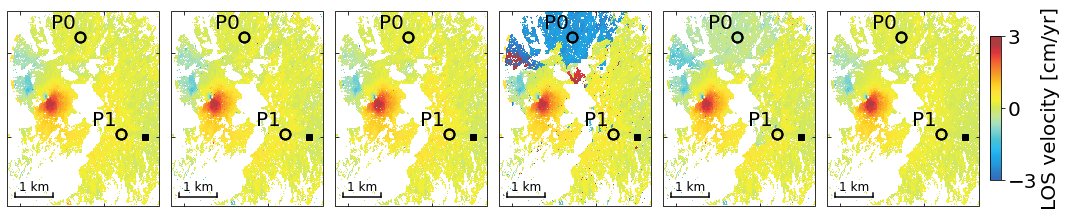

In [12]:

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()
plt.rcParams["font.size"] = "20"

#titiles = ['Single reference','Mini stacks', 'Delaunay', 'Redundant sequential', 'Non-redundant Sequential']


fsize = 12

#dem_file = os.path.expanduser('/Users/Sara/Documents/insarlab/scratch/Ecuador/DEM/demLat_S02_N02_Lon_W080_W076.dem.wgs84')

factor = [3,2,2,2]
#titles = ['Ascending', 'Descending', 'Vertical', 'East-West']

# options for view.py

#opt =  ' --dem {}  --contour-step 200 --contour-smooth 0.0 --shade-az 45 '.format(dem_file)
#opt += ' --shade-exag 0.001 --shade-min -8000 --shade-max 4000 '
opt = ' --notitle --fontsize 12 --nocbar --alpha 0.9 '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature'
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 '
opt += ' --sub-lat -0.1963 -0.1500 --sub-lon -78.6230 -78.5869 '
opt += ' --noverbose  --notitle '

fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(15,10), subplot_kw=dict(projection=ccrs.PlateCarree()))


for t in range(6):
    ax = axs[t]
    ax.set_extent([lon[0], lon[1], lat[0], lat[1]], crs=ccrs.PlateCarree())

    cmd = 'view.py {} velocity'.format(data[t]) + opt 
    cmd += ' --wrap --wrap-range -{f} {f} '.format(f=3)
    ax.set_title('Velocity', fontsize=fsize)
    d_v, atr, inps = view.prep_slice(cmd)
    im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]

    for x in range(points_lalo.shape[0]):
       
        ax.text(points_lalo[x,1]-0.001, points_lalo[x,0]+0.002, 'P{}'.format(x), fontsize=20, 
                horizontalalignment='right', transform=ccrs.PlateCarree())
              
        ax.plot(points_lalo[:,1], points_lalo[:,0], 'o', markersize=10, markerfacecolor=(0,0,0,0), 
                    markeredgecolor='k', markeredgewidth=2, transform=ccrs.PlateCarree())
        ax.set_title('')
        

cbar_ax = fig.add_axes([0.96, 0.4, 0.01, 0.2])
fig.colorbar(im, cax=cbar_ax, ticks=[-3,0,3], label='LOS velocity [cm/yr]')

#cbar=fig.colorbar(im, ax=axs[4], ticks=[-3,0,3], label='cm/yr')
fig.subplots_adjust(wspace=0.08, hspace=-0.3, left=0.05, right=0.95, top=0.95, bottom=0.05)      

out_file = os.path.abspath(out_dir + '/velocity_pichincha_6.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=300)
print('save figure to file', out_file)
plt.show()

view.py /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/single_reference_network/geocoded/diff_vel_de_sr.h5 velocity -m /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/single_reference_network/geocoded/geo_maskTempCoh.h5 --notitle --fontsize 12 --nocbar --alpha 0.9 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --sub-lat -0.1963 -0.1500 --sub-lon -78.6230 -78.5869 --noverbose --notitle --wrap --wrap-range -3 3
view.py /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/single_reference_network/geocoded/diff_vel_mi_sr.h5 velocity -m /Users/Sara/Documents/insarlab/scratch/minopy_run/PichinchaSenDT142_2/minopy/single_reference_network/geocoded/geo_maskTempCoh.h5 --notitle --fontsize 12 --nocbar --alpha 0.9 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --sub-lat -0.1963 -0.1500 --sub-lon -78.6230 

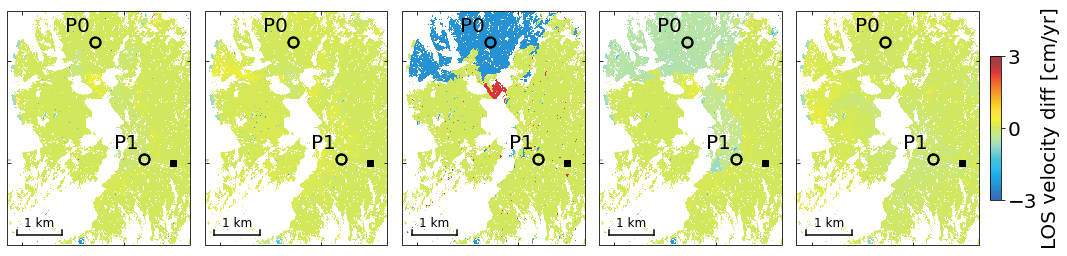

In [13]:
geocode_dir = project_dirs[0] + '/geocoded/'
out_files = ['diff_vel_de_sr.h5', 'diff_vel_mi_sr.h5', 'diff_vel_se1_sr.h5', 'diff_vel_se3_sr.h5', 'diff_vel_se8_sr.h5']
data = [geocode_dir + x for x in out_files]
mask_f = geocode_dir + 'geo_maskTempCoh.h5'

years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()
plt.rcParams["font.size"] = "20"

#titiles = ['Single reference','Mini stacks', 'Delaunay', 'Redundant sequential', 'Non-redundant Sequential']


fsize = 12

#dem_file = os.path.expanduser('/Users/Sara/Documents/insarlab/scratch/Ecuador/DEM/demLat_S02_N02_Lon_W080_W076.dem.wgs84')

factor = [3,2,2,2]
#titles = ['Ascending', 'Descending', 'Vertical', 'East-West']

# options for view.py

#opt =  ' --dem {}  --contour-step 200 --contour-smooth 0.0 --shade-az 45 '.format(dem_file)
#opt += ' --shade-exag 0.001 --shade-min -8000 --shade-max 4000 '
opt = ' --notitle --fontsize 12 --nocbar --alpha 0.9 '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature'
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 '
opt += ' --sub-lat -0.1963 -0.1500 --sub-lon -78.6230 -78.5869 '
opt += ' --noverbose  --notitle '

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15,10), subplot_kw=dict(projection=ccrs.PlateCarree()))


for t in range(5):
    ax = axs[t]
    ax.set_extent([lon[0], lon[1], lat[0], lat[1]], crs=ccrs.PlateCarree())

    cmd = 'view.py {} velocity -m {}'.format(data[t], mask_f) + opt 
    cmd += ' --wrap --wrap-range -{f} {f} '.format(f=3)
    ax.set_title('Velocity', fontsize=fsize)
    d_v, atr, inps = view.prep_slice(cmd)
    im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]

    for x in range(points_lalo.shape[0]):
       
        ax.text(points_lalo[x,1]-0.001, points_lalo[x,0]+0.002, 'P{}'.format(x), fontsize=20, 
                horizontalalignment='right', transform=ccrs.PlateCarree())
              
        ax.plot(points_lalo[:,1], points_lalo[:,0], 'o', markersize=10, markerfacecolor=(0,0,0,0), 
                    markeredgecolor='k', markeredgewidth=2, transform=ccrs.PlateCarree())
        ax.set_title('')
        

cbar_ax = fig.add_axes([0.96, 0.4, 0.01, 0.2])
fig.colorbar(im, cax=cbar_ax, ticks=[-3,0,3], label='LOS velocity diff [cm/yr]')

#cbar=fig.colorbar(im, ax=axs[4], ticks=[-3,0,3], label='cm/yr')
fig.subplots_adjust(wspace=0.08, hspace=-0.3, left=0.05, right=0.95, top=0.95, bottom=0.05)      

out_file = os.path.abspath(out_dir + '/velocity_pichincha_5_diff.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=300)
print('save figure to file', out_file)
plt.show()

In [14]:
reflat, reflon = -0.1675, -78.5967

dates_sr, x_sr, ts_sr = get_dates_ts(project_dirs[0], points_lalo, reflat, reflon, 'lalo')  # single reference
dates_de, x_de, ts_de = get_dates_ts(project_dirs[1], points_lalo, reflat, reflon, 'lalo')  # delaunay
dates_ms, x_ms, ts_ms = get_dates_ts(project_dirs[2], points_lalo, reflat, reflon, 'lalo')  # mini stacks
dates_se1, x_se1, ts_se1 = get_dates_ts(project_dirs[3], points_lalo, reflat, reflon, 'lalo')  # sequential
dates_se3, x_se3, ts_se3 = get_dates_ts(project_dirs[4], points_lalo, reflat, reflon, 'lalo')  # sequential
dates_se8, x_se8, ts_se8 = get_dates_ts(project_dirs[5], points_lalo, reflat, reflon, 'lalo')  # sequential

for i, date in enumerate(dates):
    if datetime.datetime.strptime(date, '%Y%m%d') not in dates_sr:
        del dates[i]

input lat / lon: -0.1562 / -78.6056
corresponding y / x: 175 / 1138
input lat / lon: -0.1793 / -78.596
corresponding y / x: 338 / 587
input lat / lon: -0.1562 / -78.6056
corresponding y / x: 175 / 1138
input lat / lon: -0.1793 / -78.596
corresponding y / x: 338 / 587
input lat / lon: -0.1562 / -78.6056
corresponding y / x: 175 / 1138
input lat / lon: -0.1793 / -78.596
corresponding y / x: 338 / 587
input lat / lon: -0.1562 / -78.6056
corresponding y / x: 175 / 1138
input lat / lon: -0.1793 / -78.596
corresponding y / x: 338 / 587
input lat / lon: -0.1562 / -78.6056
corresponding y / x: 175 / 1138
input lat / lon: -0.1793 / -78.596
corresponding y / x: 338 / 587
input lat / lon: -0.1562 / -78.6056
corresponding y / x: 175 / 1138
input lat / lon: -0.1793 / -78.596
corresponding y / x: 338 / 587


In [15]:
ts_sr.shape, ts_de.shape, ts_ms.shape, ts_se3.shape, ts_se1.shape, ts_se8.shape

((2, 46), (2, 46), (2, 46), (2, 46), (2, 46), (2, 46))

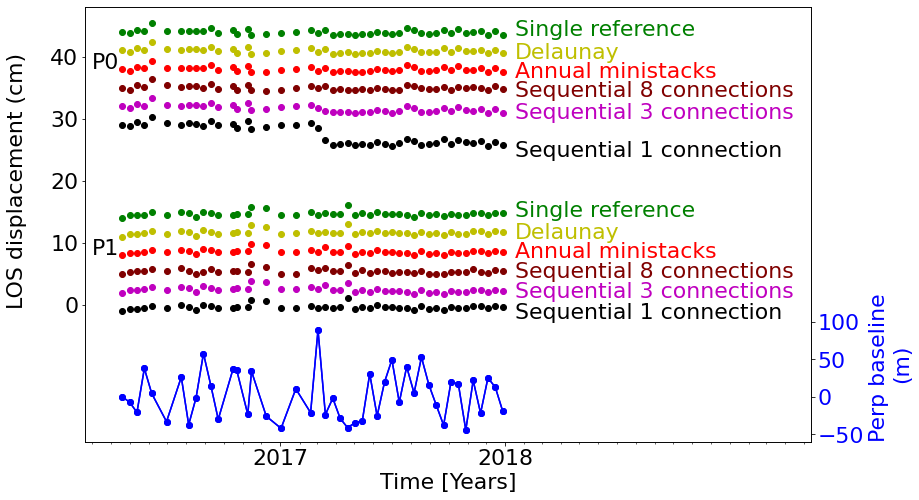

In [27]:
plt.rcParams["font.size"] = "22"
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()

colors = ['lightcoral', 'darkviolet','aquamarine','springgreen','forestgreen','darkgreen']

shifts = [14,11,8,5,2, -1]
lsh = np.array([[13.8,10.2,7,3.8,1.0, -3],
                [13.5,10.0,7,3.9,.8, -3]])


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(13, 8))

msize = 15
fsize=8

shift = [30.0, 0]

labels = ['Single reference', 'Delaunay','Annual ministacks','Sequential 3 connections',
          'Sequential 8 connections', 'Sequential 1 connection']

ax1 = axs
ax2 = ax1.twinx()

bslines = np.array([baselines[x] for x in np.sort(dates)])

for t in range(len(points_lalo)):
    ax1.plot(dates_sr, ts_sr[t, :] - ts_sr[t, 0] + shifts[0] + shift[t], 'go',markersize=6, linewidth=1)
    
    ax1.plot(dates_ms, ts_ms[t, :] - ts_ms[t, 0] + shifts[1] + shift[t], 'yo',markersize=6,  linewidth=1)
    ax1.plot(dates_de, ts_de[t, :] - ts_de[t, 0] + shifts[2] + shift[t], 'ro',markersize=6,  linewidth=1)
    
    ax1.plot(dates_se8, ts_se8[t, :] - ts_se8[t, 0] + shifts[3]+ shift[t], 'o',markersize=6,  linewidth=1, color='maroon')

    ax1.plot(dates_se3, ts_se3[t, :] - ts_se3[t, 0] + shifts[4]+ shift[t], 'mo',markersize=6,  linewidth=1)
    
    ax1.plot(dates_se1, ts_se1[t, :] - ts_se1[t, 0] + shifts[5]+ shift[t], 'ko',markersize=6,  linewidth=1)
    
    ax2.plot(dates_sr, bslines, 'bo-', markersize=6)
    
    ax1.text(dates_ms[-1] + datetime.timedelta(days=20), 
             ts_ms[t, -1] - ts_ms[t, 0] + lsh[t,0]+ shift[t], 
             labels[0], color='g')
    
    ax1.text(dates_sr[-1] + datetime.timedelta(days=20), 
             ts_sr[t, -1] - ts_sr[t, 0] + lsh[t,1]+ shift[t], 
             labels[1], color='y')
    
    ax1.text(dates_de[-1] + datetime.timedelta(days=20), 
             ts_de[t, -1] - ts_de[t, 0] + lsh[t,2]+ shift[t], 
             labels[2], color='r')
    
    ax1.text(dates_se8[-1] + datetime.timedelta(days=20), 
             ts_se8[t, -1] - ts_se8[t, 0] + lsh[t,3]+ shift[t], 
             labels[4], color='maroon')
    
    ax1.text(dates_se3[-1] + datetime.timedelta(days=20), 
             ts_se3[t, -1] - ts_se3[t, 0] + lsh[t,4]+ shift[t], 
             labels[3], color='m')
    
    ax1.text(dates_se1[-1] + datetime.timedelta(days=20), 
             ts_se1[t, -1] - ts_se1[t, 0] + lsh[t,5]+ shift[t], 
             labels[5], color='k')
    
    ax1.xaxis.set_major_locator(years)
    ax1.xaxis.set_major_formatter(years_fmt)
    ax1.xaxis.set_minor_locator(months)
    ax1.autoscale_view()
    
ax1.text(dates_se3[0]-datetime.timedelta(days=50) , (ts_sr[0, -1] - (ts_de[0, -1]))+ shifts[2]+shift[0], 'P0')
ax1.text(dates_se3[0]-datetime.timedelta(days=50) , (ts_sr[1, -1] - (ts_de[1, -1]))+ shifts[2]+shift[1], 'P1')
#ax1.text(dates_se[-1]+datetime.timedelta(days=20) , (ts_sr[t, -1] - (ts_de[t, -1]))*4*np.pi/56 + shift[2]-1, 'P2', size=20)

ax1.set_xlim(dates_se3[0]-datetime.timedelta(days=60), dates_se3[-1]+datetime.timedelta(days=500))
#ax1.legend(('Single reference','Mini stacks', 'Delaunay','Fully connected sequential','Partially connected sequential'), 
#           loc='lower left', bbox_to_anchor=(0,-1))

ax2.set_ylim(-60, 520)
ax1.set_ylim(-22.0, 48.0)
ax2.set_ylabel('Perp baseline \n(m)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_ylabel('LOS displacement (cm)')

ax1.set_xlabel('Time [Years]')

ax2.set_yticks((-50, 0, 50, 100))
ax1.set_yticks((0, 10, 20, 30, 40))
ax1.yaxis.set_label_coords(-0.08, 0.6)
ax2.yaxis.set_label_coords(1.08, 0.18)
ax1.set_xticks((datetime.datetime(2017, 1, 1, 0, 0), 
                datetime.datetime(2018, 1, 1, 0, 0)))
plt.savefig(out_dir + '/Pichincha_timeseries_unwrap_compare6.png', bbox_inches='tight', transparent=True, dpi=300)

plt.show()


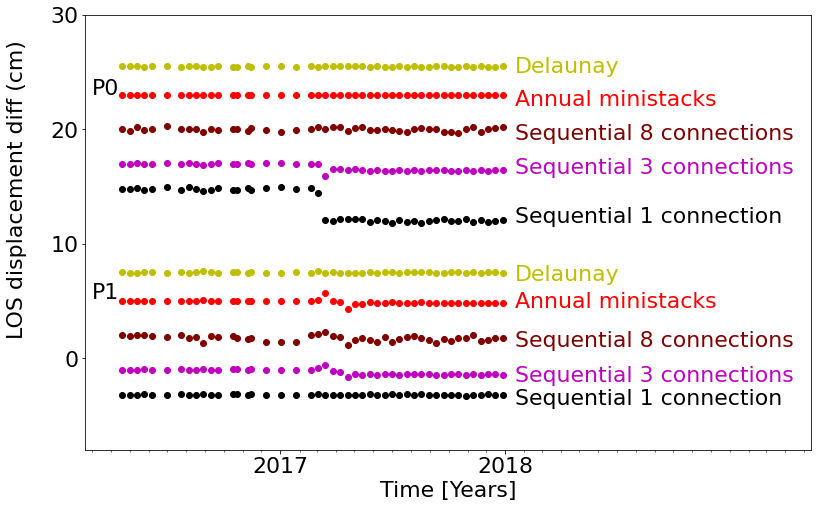

In [44]:
plt.rcParams["font.size"] = "22"
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')
months = mdates.MonthLocator()

colors = ['lightcoral', 'darkviolet','aquamarine','springgreen','forestgreen','darkgreen']

shifts = [2,7.5,5,2,-1, -3.2]
lsh = np.array([[2,7.4,4.5,1.4,-0.9, -3],
                [2,6,3.8,0.5,-2.4, -4.8]])


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(13, 8))

msize = 15
fsize=8

shift = [18.0, 0]

labels = ['Delaunay','Annual ministacks','Redundant sequential',
          'Non-redundant sequential']
labels = ['Delaunay','Annual ministacks','Sequential 3 connections',
          'Sequential 8 connections', 'Sequential 1 connection']

ax1 = axs
#ax2 = ax1.twinx()

bslines = np.array([baselines[x] for x in np.sort(dates)])

for t in range(len(points_lalo)):
    srts = ts_sr[t, :] - ts_sr[t, 0]
        
    ax1.plot(dates_ms, ts_ms[t, :] - ts_ms[t, 0] - srts + shifts[1]+ shift[t], 'yo',markersize=6,  linewidth=1)
    ax1.plot(dates_de, ts_de[t, :] - ts_de[t, 0] - srts + shifts[2]+ shift[t], 'ro',markersize=6,  linewidth=1)
    ax1.plot(dates_se8, ts_se8[t, :] - ts_se8[t, 0] - srts + shifts[3]+ shift[t], 'o',markersize=6,  linewidth=1, color='maroon')
    ax1.plot(dates_se3, ts_se3[t, :] - ts_se3[t, 0] - srts + shifts[4]+ shift[t], 'mo',markersize=6,  linewidth=1)
    
    ax1.plot(dates_se1, ts_se1[t, :] - ts_se1[t, 0] - srts + shifts[5]+ shift[t], 'ko',markersize=6,  linewidth=1)
    
    #ax2.plot(dates_sr, bslines, 'bo-', markersize=6)
    
    
    ax1.text(dates_sr[-1] + datetime.timedelta(days=20), 
             ts_sr[t, -1] - ts_sr[t, 0] + lsh[t,1]+ shift[t], 
             labels[0], color='y')
    
    ax1.text(dates_de[-1] + datetime.timedelta(days=20), 
             ts_de[t, -1] - ts_de[t, 0] + lsh[t,2]+ shift[t], 
             labels[1], color='r')
    
    ax1.text(dates_se8[-1] + datetime.timedelta(days=20), 
             ts_se8[t, -1] - ts_se8[t, 0] + lsh[t,3]+ shift[t], 
             labels[3], color='maroon')
    
    ax1.text(dates_se3[-1] + datetime.timedelta(days=20), 
             ts_se3[t, -1] - ts_se3[t, 0] + lsh[t,4]+ shift[t], 
             labels[2], color='m')
    
    ax1.text(dates_se1[-1] + datetime.timedelta(days=20), 
             ts_se1[t, -1] - ts_se1[t, 0] + lsh[t,5]+ shift[t], 
             labels[4], color='k')
    
    ax1.xaxis.set_major_locator(years)
    ax1.xaxis.set_major_formatter(years_fmt)
    ax1.xaxis.set_minor_locator(months)
    ax1.autoscale_view()
    
ax1.text(dates_se3[0]-datetime.timedelta(days=50) , (ts_sr[0, -1] - (ts_de[0, -1]))+ shifts[2]+shift[0], 'P0')
ax1.text(dates_se3[0]-datetime.timedelta(days=50) , (ts_sr[1, -1] - (ts_de[1, -1]))+ shifts[2]+shift[1], 'P1')
#ax1.text(dates_se[-1]+datetime.timedelta(days=20) , (ts_sr[t, -1] - (ts_de[t, -1]))*4*np.pi/56 + shift[2]-1, 'P2', size=20)

ax1.set_xlim(dates_se3[0]-datetime.timedelta(days=60), dates_se3[-1]+datetime.timedelta(days=500))
#ax1.legend(('Single reference','Mini stacks', 'Delaunay','Fully connected sequential','Partially connected sequential'), 
#           loc='lower left', bbox_to_anchor=(0,-1))

#ax2.set_ylim(-60, 520)
ax1.set_ylim(-8, 28)
#ax2.set_ylabel('Perp baseline \n(m)', color='blue')
#ax2.tick_params(axis='y', labelcolor='blue')

ax1.set_ylabel('LOS displacement diff (cm)')

ax1.set_xlabel('Time [Years]')

#ax2.set_yticks((-50, 0, 50, 100))
ax1.set_yticks((0, 10, 20, 30))
ax1.yaxis.set_label_coords(-0.08, 0.6)
#ax2.yaxis.set_label_coords(1.08, 0.18)
ax1.set_xticks((datetime.datetime(2017, 1, 1, 0, 0), 
                datetime.datetime(2018, 1, 1, 0, 0)))
plt.savefig(out_dir + '/Pichincha_timeseries_unwrap_compare_diff5.png', bbox_inches='tight', transparent=True, dpi=300)

plt.show()


In [12]:
tsStack_minopy = project_dirs[0] + '/timeseries_ERA5_demErr.h5'
gStack_minopy = project_dirs[0] + '/inputs/geometryRadar.h5'

attr_minopy = readfile.read_attribute(tsStack_minopy)

coord_minopy = ut.coordinate(attr_minopy, gStack_minopy)

# P1
yg_minopy1, xg_minopy1 = coord_minopy.geo2radar(points_lalo[0][0], points_lalo[0][1])[0:2]
vec_refined_1, temp_quality_1, coh_mat_1, shp_1, amp_1, data_1, col0_1, row0_1 = process_pixel((yg_minopy1, xg_minopy1), prj_dir + '/inputs/slcStack.h5')

# P2
yg_minopy2, xg_minopy2 = coord_minopy.geo2radar(points_lalo[1][0], points_lalo[1][1])[0:2]
vec_refined_2, temp_quality_2, coh_mat_2, shp_2, amp_2, data_2, col0_2, row0_2 = process_pixel((yg_minopy2, xg_minopy2), prj_dir + '/inputs/slcStack.h5')

(100, 100)
0.8295021713217169
(100, 100)
0.7000222226157209


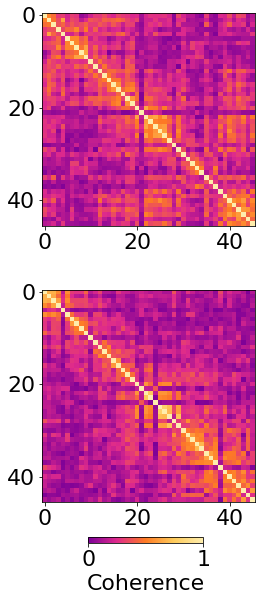

In [13]:
plt.rcParams["font.size"] = "22"
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

ax = axs[0]
im=ax.imshow(np.abs(np.array(coh_mat_1)), vmin=0, vmax=1, cmap=cmapc)
ax = axs[1]
ax.imshow(np.abs(np.array(coh_mat_2)), vmin=0, vmax=1, cmap=cmapc)

cbar_ax2 = fig.add_axes([0.42, 0.03, 0.2, 0.01])
#cbar_ax2 = fig.add_axes([0.5, 0.01, 0.005, 0.15, ])
fig.colorbar(im, cax=cbar_ax2, ticks=[0, 1], label='Coherence', orientation='horizontal')
fig.subplots_adjust(wspace=0.1, hspace=0.3, left=0.1, right=0.95, top=0.95, bottom=0.1)      

plt.savefig(out_dir + '/Pichincha_timeseries_unwrap_compare_coh_matrix.png', bbox_inches='tight', transparent=True, dpi=300)
